# An experiment in community policing, based on Minneapolis Police stop data

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import datetime
import time
import scipy.stats as stats
from IPython.display import display, Markdown, Latex
%matplotlib inline

## Functions

In [101]:
def severity_contingency(df):
    df_pivot = pd.DataFrame
    return_dict = {}
    for in_race in df['race'].unique():
        df_pivot = df.loc[(df['race'] == in_race)]\
                     .pivot(index='callDisposition',columns='problem',values='count')
        # The chi2_contingency function doesn't like NaNs
        df_pivot.fillna(value=0,inplace=True)
        chi2_stat, p_value, dof, jarr = stats.chi2_contingency(df_pivot)
        crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                              df = dof)
        return_dict[in_race] = {'chi2_stat': chi2_stat, 'p_value': p_value, 'dof': dof, 'crit': crit}
    return return_dict

In [102]:
def severity_dict_print(dict):
    for in_race in dict.keys():
        print("For {}:\n Chi-squared statistic: {}\n P-value: {}\n Degrees of freedom: {}\n Critical value: {}\n"\
              .format(in_race,
                      dict[in_race]['chi2_stat'],
                      dict[in_race]['p_value'],
                      dict[in_race]['dof'],
                      dict[in_race]['crit']
                     )
             )

In [47]:
def chi2_racial_bias(population,observed):
    population = population.sort_index()
    print("\nPopulation\n", population['count'])
    observed_counts = observed.value_counts().sort_index()
    print("\nObserved counts\n", observed_counts)
    expected = population['percentage'] * len(observed)
    print("\nExpected counts\n",expected)
    chi_squared_stat = (((observed_counts - expected)**2) / expected).sum()
    print("\nChi^2 stat:\n",chi_squared_stat)

    crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 6)   # Df = number of variable categories - 1

    print("Critical value")
    print(crit)

    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=len(observed) - 1)
    print("P value")
    print(p_value)

## Exploring the data set

This data set was obtained from [Minneapolis' Open Data site](http://opendata.minneapolismn.gov/datasets/police-stop-data). It covers police calls from the evening of October 31st, 2016, until early morning on May 13th, 2019.

Metadata can be found [here](https://www.arcgis.com/home/item.html?id=215b4b543d894750aef86c725b56ee2a).


In [48]:
df = pd.read_csv('Police_Stop_Data.csv')

### Context

__Minneapolis is divided into five major police precincts__--downtown, and the four corners of the city:

1. Downtown precinct
2. Northeast precinct
3. Southeast precinct
4. Northwest precinct
5. Southwest precinct

[Here's a map of the Minneapolis Police precincts](http://www.minneapolismn.gov/www/groups/public/@mpd/documents/webcontent/wcmsp-212155.pdf).

The First Precinct downtown has the fewest residents, but is the home to the city's largest entertainment venues and businesses.

[Minneapolis has a history of racial segregation in housing](https://www.minnpost.com/metro/2019/02/with-covenants-racism-was-written-into-minneapolis-housing-the-scars-are-still-visible/), and while these deeds and covenants have been unenforceable in Minnesota since 1953, the patterns they created still exist within the city today. This means that the Fourth Precinct in particular is home to a large percentage of the city's African American population.

The Second Precinct has historically been very white--primarily people having eastern European ancestry--but has become more diverse in recent decades.

Minneapolis has seen an influx of East African and Latinx populations in particular in the past few decades. Members of these groups have mostly settled in the Fourth Precinct, around the West Bank near the University of Minnesota (Second Precinct), and south of downtown, in the Ventura Village, Phillips, and Powderhorn neighborhoods (Third Precinct).

The East Phillips neighborhood (Third Precinct) is also home to the [Little Earth development](https://www.littleearth.org/about-us/), whose residents are 98% Native American, and largely living below the poverty line.

The Fifth Precinct is mostly wealthier, more educated, and predominantly white, except for the Whittier neighbhorhood, adjacent to downtown. This precinct also contains the Chain of Lakes park system, which attracts a large number of people from all backgrounds, presenting its own set of policing challenges.

A Minneapolis neighborhood map is [here](https://en.wikipedia.org/wiki/Neighborhoods_of_Minneapolis#/media/File:MinneapolisNeighborhoodsAndCommunities.PNG).


### Minneapolis demographics

As you look at the following graphs, keep in mind that [this is how Minneapolis' demographics break down](https://www.census.gov/quickfacts/minneapoliscityminnesota):

* ~~White alone, percent	63.9%~~ This number includes people who also identify as Hispanic. Use the percentage for White people below that does not include Hispanic people.
* Black or African American alone, percent(a)	18.9%
* American Indian and Alaska Native alone, percent(a)	1.2%
* Asian alone, percent(a)	6.0%
* Native Hawaiian and Other Pacific Islander alone, percent(a)	0.0%
* Two or More Races, percent	4.9%
* Hispanic or Latino, percent(b)	9.8%
* White alone, not Hispanic or Latino, percent	59.9%

    <sub>(a)Includes persons reporting only one race<br>
    (b)Hispanics may be of any race, so also are included in applicable race categories</sub>

I am following [the Minneapolis municipal website's](http://www.minneapolismn.gov/ncr/engagement/WCMS1P-143464) suggested population numbers for its East African community:

> Precise population numbers are difficult to determine for the East African community, many community members do not participate in the census due to cultural reasons. However, _community members estimate that there are roughly 50,000 East Africans that call Minneapolis their home_.


Some high-level demographic information, specifically about the percentage of people of color in a given neighborhood of Minneapolis, is [here](https://www.mncompass.org/profiles/neighborhoods/minneapolis-saint-paul#!percent-of-color). (This map also covers neighboring Saint Paul.)

I'm translating these percentages into a dataframe, which we will use for comparisons later.

In [49]:
total_population = 425403
df_population = pd.DataFrame(data={'percentage': [18.9/100, 59.9/100, 6.0/100, 1.2/100, 9.8/100, 50000/425403, 4.9/100]},
                             index=['Black','White','Asian','Native American','Latino','East African','Other'],
                            )

df_population['count'] = round(df_population['percentage'] * total_population,0)
df_population

,percentage,count
Black,0.189000,80401.0
White,0.599000,254816.0
Asian,0.060000,25524.0
Native American,0.012000,5105.0
Latino,0.098000,41689.0
East African,0.117536,50000.0
Other,0.049000,20845.0


## Where policing happens most frequently

In [50]:
df['neighborhood'].value_counts().sort_values(ascending=False).head(10)

Downtown West      11276
Whittier            6434
Hawthorne           5261
Near - North        5164
Marcy Holmes        4555
Jordan              4553
Lyndale             4259
Lowry Hill East     3250
East Phillips       2970
Willard - Hay       2889
Name: neighborhood, dtype: int64

With the exceptions of Downtown West, Whittier, and East Phillips, all of the neighbhorhoods with the highest number of overall calls are in the Fourth Precinct in the northwest quadrant of the city. Whittier is in the corner of the Fifth Precinct adjacent to downtown; East Phillips is in the northeast part of the Third Precinct.

## To what kinds of calls do the police respond?

There are just six basic categories for the 'problem' to which the police are responding on each call. Most of the problem descriptions are self-explanatory; "Attempt Pick-Up" is the attempt to exercise an arrest warrant. Here are the categories and their frequency for the entire set of data:

In [51]:
df['problem'].value_counts()

Traffic Law Enforcement (P)    60220
Suspicious Person (P)          33145
Suspicious Vehicle (P)         24807
Attempt Pick-Up (P)             2880
Curfew Violations (P)            112
Truancy (P)                       49
Name: problem, dtype: int64

Each precinct has its own unique characteristics, so the most frequent types of calls can differ between them. This bar chart illustrates how frequent each type of problem is in each precinct.

Note that the y-axis is logarithmic. This is to help manage the difference between the frequent problems, with thousands of incidents, to the less frequent problems, with very few incidents.

In [52]:
df_precinct_problem = df.groupby(['policePrecinct','problem']).size().reset_index(name='count')

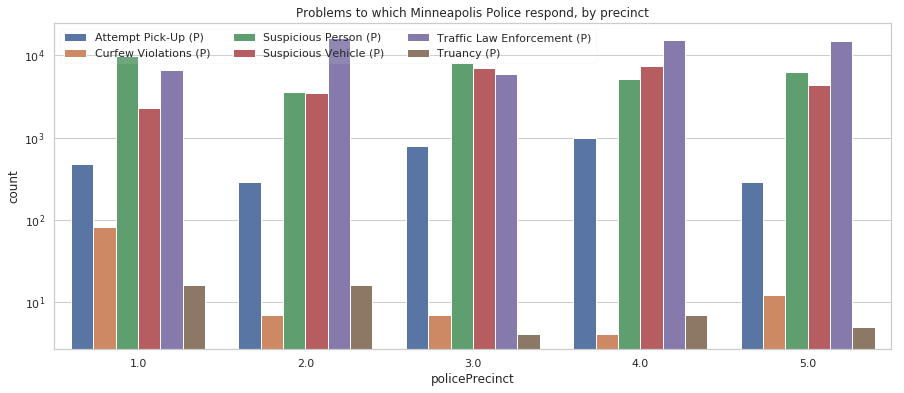

In [53]:
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x='policePrecinct',
            y='count',
            hue='problem',
            data=df_precinct_problem,
           )
title = ax.set_title("Problems to which Minneapolis Police respond, by precinct")
legend = ax.legend(ncol=3,framealpha=.1)
yscale = ax.set(yscale="log")

Traffic stops are by far the most common problem in Minneapolis overall, and are the primary reason for calls in the Second, Fourth, and Fifth precincts. __Update, 2019/06/06:__ just as I was wrapping up this research, a local news site, Minnpost, published an article that I believe helps explain the high number of traffic stops. See the addendum.

Suspicious Person is the most frequent problem in the First and Third Precincts. 

__Here are the most frequent problems, by precinct and race:__

When race is also considered, a pattern emerges that crosses precinct lines: Black people are by far the most frequently involved in police stops, despite being only 18.9% of the city's population.

In [54]:
df_precinct_race_problem = df.groupby(['policePrecinct','race','problem']).size().reset_index(name='count')
df_precinct_race_problem.sort_values(by='count',ascending=False)
#df_precinct_race_problem['policePrecinct'].unique()

,policePrecinct,race,problem,count
129,4.0,Black,Traffic Law Enforcement (P),10370
81,2.0,White,Traffic Law Enforcement (P),6494
195,5.0,White,Traffic Law Enforcement (P),6403
49,2.0,Black,Traffic Law Enforcement (P),4099
166,5.0,Black,Traffic Law Enforcement (P),3929
151,4.0,Unknown,Suspicious Vehicle (P),3374
114,3.0,Unknown,Suspicious Vehicle (P),3371
113,3.0,Unknown,Suspicious Person (P),3258
7,1.0,Black,Suspicious Person (P),3121
9,1.0,Black,Traffic Law Enforcement (P),2462


[None]

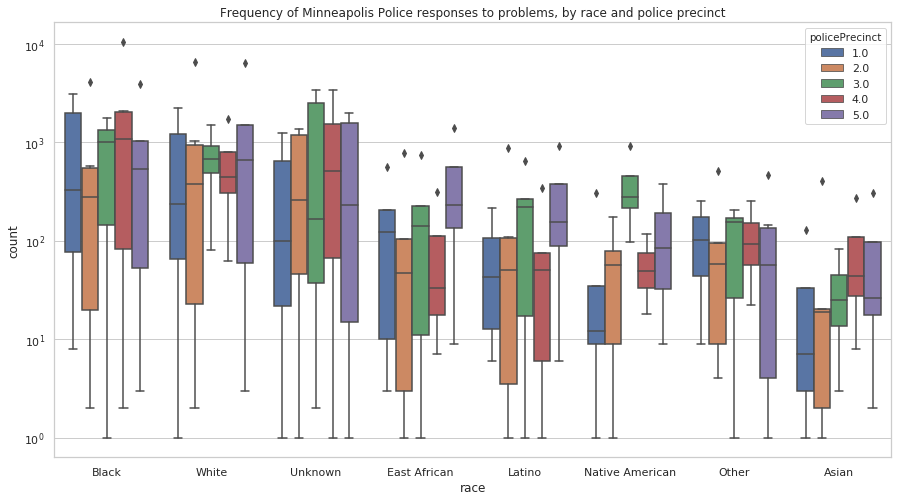

In [57]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x='race',
            y='count',
            hue='policePrecinct',
            data=df_precinct_race_problem,
            order=df['race'].value_counts().index, # Order race on x-axis by overall frequency
           )
ax.set_title("Frequency of Minneapolis Police responses to problems, by race and police precinct")
ax.set(yscale="log")

__The box plot above shows the range of frequencies of problems for which a particular race is involved in a call, per precinct.__ The races are in order of most frequently involved in overall calls, to least frequent.

Some points of interest:
* Black people are involved in police calls more often than any other race overall, despite being only 18.9% of the city's population. They are most frequently involved in calls in all but the Second precinct, and are far and away the most frequent in the Fourth precinct. (I needed to use a logarithmic scale for this graph because the values for the city's Black population flattened most of the other groups' data against the x-axis.)

* Calls involving White people--by percentage the largest racial group in the city, representing 59.9% of the population--are second in the list, and are most frequently the subjects of calls in the Second and Fifth precincts, where they are predominant.

* East African and Latinx people are frequently involved in calls in the Third precinct, where their communities are centered within the city, and also in the Fifth. (Traffic stops are by far the most common in the Fourth and Fifth precincts.)

* Calls involving Native Americans are most frequent in the Third precinct, the location of the Little Earth community.

__Because traffic stops are so frequent, I wanted to see how those broke down by race and precinct as well.__ The results are sort of predictable at this point--Black and White people are at the top, followed by East Africans and Latinxs, with the other categories 

[None]

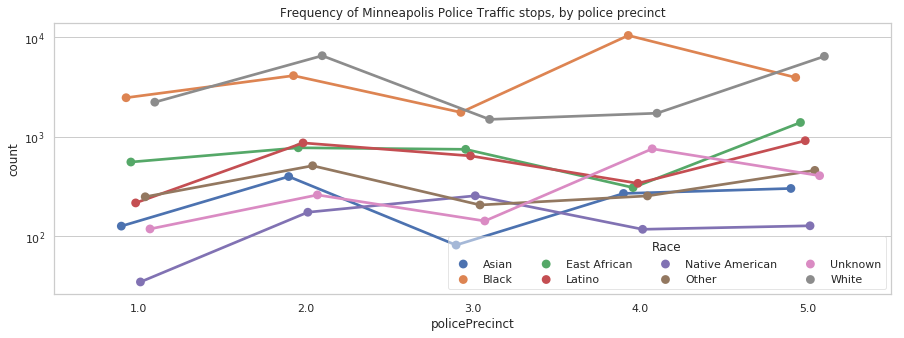

In [166]:
fig, ax = plt.subplots(figsize=(15,5))
sns.set(style='whitegrid')
sns.pointplot(x='policePrecinct',
              y='count',
              hue='race',
              data=df_precinct_race_problem\
                .loc[df_precinct_race_problem['problem'] == 'Traffic Law Enforcement (P)'],
              dodge=True,
           )
ax.legend(title='Race',
          loc='lower right',
          ncol=4,
          framealpha=.5,
         )
title = ax.set_title("Frequency of Minneapolis Police Traffic stops, by police precinct")
ax.set(yscale="log")

In [62]:
df.loc[df['problem'] == 'Traffic Law Enforcement (P)']['reason'].value_counts()

Moving Violation       26183
Equipment Violation    14000
Investigative           3886
Citizen / 9-1-1          145
Name: reason, dtype: int64

## Call disposition

When a call is resolved, officers choose a call disposition from a predefined list of values. The purpose of some of these values overlap, and a few are described by their own metadata as interchangeable. There's also a lengthy list of dispositions that are primarily administrative in nature. [The MPD data dashboard](https://www.insidempd.com/datadashboard/) includes an explanation of call dispositions.

For this research, I am concerned with understanding just a few higher-level categories:
* Was someone arrested?
* Was some kind of citation issued?
* Did the person involved get away with just a warning?

Given the explanations provided for each disposition, I grouped dispositions into these three categories, and a few additional categories:

1. __Arrested - Call ended with someone being arrested__

2. __Ticket/tow - Call ended with a ticket being issued.__ In addition to moving violations, these dispositions can apply to parking violations where the race of the driver is unknown, because the driver was not present.

3. __Advised - Call ended with a verbal warning and/or someone being obliged to leave the scene.__ A disposition I did not see explained on the MPD data dashboard is "LOP", or [Lights On Program](https://www.lightsonus.org/). Because this program offers repair vouchers to the economically disadvantaged in lieu of issuing tickets, I categorized this disposition as advisory.

4. Transported - Call ended with someone being transported away from the scene (a truancy or detox situation).

5. No action - Call ended with nothing happening to the subject--service was not provided (or refused), or a calling card was left.

6. Administrative - Includes informational dispositions, calls that ended as a false alarm, the suspects were not at the scene when police arrived, or the issue was already resolved when they arrived.

In [55]:
arrested = ['BKG-Booking','BKG-Booking,TOW-Towed']
transported = ['TRN-Transport','DTX-Detox']
ticket_tow = ['TAG-Tagged','TOW-Towed','RPT-Report,TAG-Tagged']
advised = ['ADV-Advised','SNT-Sent','RPR-Reprimand/Release','LOP-Lights On Program']
no_action = ['NOS-No Service','RFD-Refused','MES-Message Left']
administrative = ['GOA-Gone on Arrival','AOK- All OK','UTL-Unable to Locate','INF-Information','CNL-Cancel',
                  'UNF-Unfounded','INS-Inservice','AQT-All Quiet','FTC-Fail to Clear','FAL-False','SCK-Sick',
                  'SEC- Secured']

Overall call disposition frequencies look like this:

In [56]:
df['callDisposition'].value_counts()

ADV-Advised              51000
TAG-Tagged               16083
GOA-Gone on Arrival      13747
BKG-Booking               8034
AOK- All OK               7529
SNT-Sent                  6594
RPT-Report                4282
UTL-Unable to Locate      2821
INF-Information           2545
TRN-Transport             1486
CNL-Cancel                 945
NOS-No Service             814
TOW-Towed                  782
UNF-Unfounded              658
INS-Inservice              545
AQT-All Quiet              529
RPR-Reprimand/Release      164
FTC-Fail to Clear          149
LOP-Lights On Program       66
SEC- Secured                63
FAL-False                   55
RFD-Refused                 48
DTX-Detox                   40
SCK-Sick                    20
MES-Message Left             5
BKG-Booking,TOW-Towed        1
RPT-Report,TAG-Tagged        1
Name: callDisposition, dtype: int64

__Here's a plot of these interactions, broken down by race:__

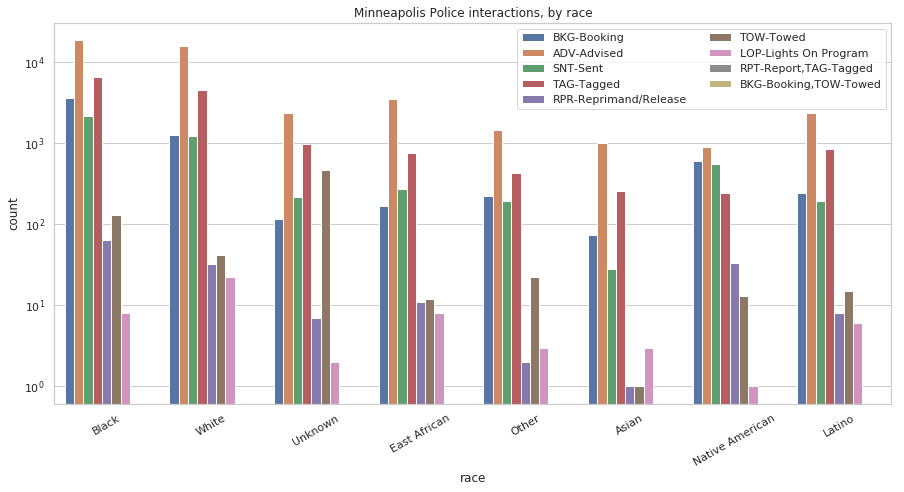

In [58]:
interactions = sum([arrested,ticket_tow,advised],[])
df_interactions = df.loc[df['callDisposition'].isin(interactions)]
fig = plt.subplots(figsize=(15,7))
prob = sns.countplot(x="race",
                     hue="callDisposition",
                     data=df_interactions,
                   )
prob.set(yscale="log")
x_title = prob.set_title("Minneapolis Police interactions, by race")
x_label = prob.set_xticklabels(prob.get_xticklabels(), rotation=30)
x_legend = prob.legend(loc='upper right',ncol=2)

Minneapolis Police interact with Black people more than any other race, except in two categories: TOW, for which Unknown is the overwhelming winner (presumably, this represents illegally parked vehicles with no driver present), and LOP, which again is the Lights On Program, where officers issue vouchers for minor repairs to the economically disadvantaged, instead of writing tickets.

I took a closer look at just arrests, broken into categories based on "reason". 

In [164]:
df_arrests = df.loc[(df['callDisposition'].isin(arrested))]
df_ticketed = df.loc[(df['callDisposition'].isin(ticket_tow))]
df_advisory = df.loc[(df['callDisposition'].isin(advised))]

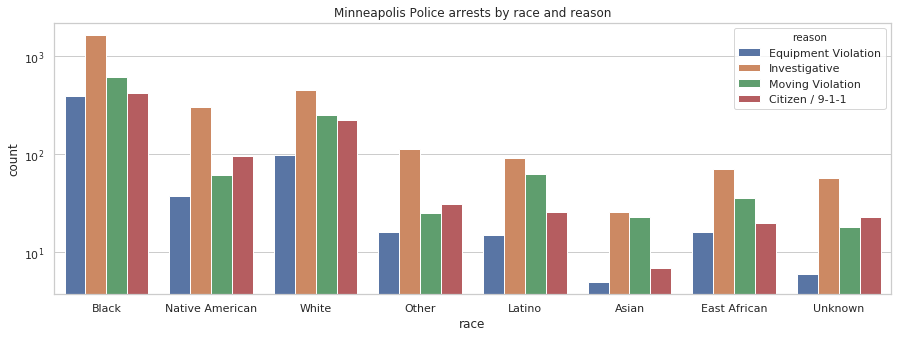

In [165]:
fig, ax = plt.subplots(figsize=(15,5))
arr = sns.countplot(x="race",
                  hue="reason",
                  data=df_arrests
                 )
arr.set(yscale="log")
x_title = arr.set_title("Minneapolis Police arrests by race and reason")

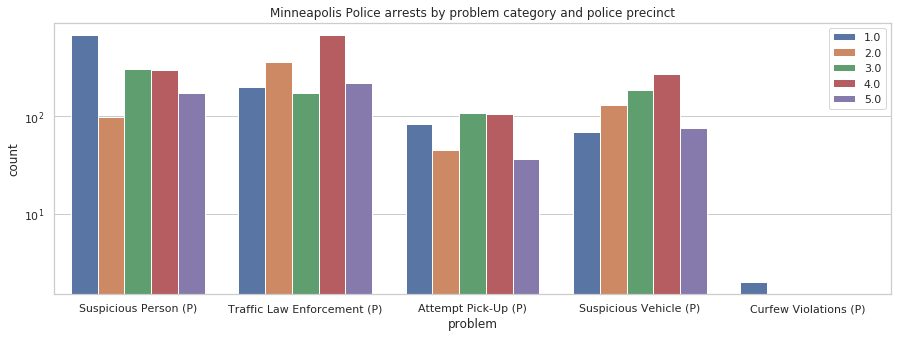

In [66]:
fig, ax = plt.subplots(figsize=(15,5))
prob = sns.countplot(x="problem",
                    hue="policePrecinct",
                    data=df_arrests,
                   )
prob.set(yscale="log")
x_title = prob.set_title("Minneapolis Police arrests by problem category and police precinct")
#x_label = prob.set_xticklabels(prob.get_xticklabels(), rotation=30)
x_legend = prob.legend(loc='upper right')

([Curfew violations](https://www.hennepinattorney.org/prevention/students-youth/curfew) are rare, and have to date happened entirely in the downtown precinct.)

Because the frequency of arrests for Black people is so far out of proportion to their percentage of the city's population, I became curious about the actual odds of a police call ending with an arrest, if the person is black, versus white, or just out of curiosity, East African:

In [68]:
df_arrests['race'].value_counts()

Black              2567
White               815
Native American     400
Other               156
Latino              149
East African        113
Asian                44
Name: race, dtype: int64

### Overall probability of a call ending in an arrest, given a specific race (example: probability of being arrested if the person involved is black):

__P(arrested|Black)__ = P(Black|arrested) * P(arrested) / P(Black) = 0.07088027391208306 = __7.0880%__

`
P(arrested) = 4244 / 121213 = 0.035012746157590355
P(Black) = 36216 / 121213 = 0.2987798338462046
P(Black|arrested) = 2567 / 4244 = 0.6048539114043355
`
### For contrast, the probability of a call ending in an arrest, given that the person is White:

__P(arrested|White)__ = P(White|arrested) * P(arrested) / P(White) = 0.030775621176648286 = 0.030775621176648286 = __3.0776%__

`
P(White) = 26482 / 121213 = 0.2184749160568586
P(White|arrested) = 815 / 4244 = 0.19203581526861452
`

### Further contrast--East African: 
__P(arrested|East African)__ = P(East African|arrested) * P(arrested) / P(East African) = 0.021606118546845122 = __2.1606%__

`
P(East African|arrested) = 113 / 4244 = 0.026625824693685202
P(East African) = 5230 / 121213 = 0.04314718718289293
`

### Overall probability police interaction, given a specific race category
This is simply about which races are most likely to experience some interaction with the city's police department.

### Black:

__P(interaction|Black)__ = P(Black|interaction) * P(interaction) / P(Black) = 0.8513916500994037 = __85.1392%__

`
P(interaction) = 82725 / 121213 = 0.6824763020468102
P(Black) = 36216 / 121213 = 0.2987798338462046
P(Black|interaction) = 30834 / 82725 = 0.3727289211242067
`
### White:

__P(interaction|White)__ = P(White|interaction) * P(interaction) / P(White) = 0.864209651838985 = __86.4210%__

`
P(White) = 26482 / 121213 = 0.2184749160568586
P(White|interaction) = 22886 / 82725 = 0.2766515563614385
`
### East African: 
__P(interaction|East African)__ = P(East African|interaction) * P(interaction) / P(East African) = 0.9061185468451244 = __90.6119%__

`
P(East African|interaction) = 4739 / 82725 = 0.057286189181021456
P(East African) = 5230 / 121213 = 0.04314718718289293
`

It's disappointing that the percentages for Black and White people are the same, given the much larger number of White people in the city.

The city's East African community is even smaller than its Black community, so that last stat is disturbing!

## What to do?

After looking at this data, one solution I thought the Minneapolis Police should consider is implicit bias training for its officers. [This PBS NewsHour segment](https://www.pbs.org/newshour/show/this-police-training-uncovers-the-implicit-bias-in-all-of-us) explores the concept of implicit bias (emphasis mine):

>__Charlayne Hunter-Gault:__<br>
>But that leads me to the definition. What is implicit bias?

>__Lorie Fridell:__<br>
>So, explicit bias would be like a racist. It's conscious. It's deliberate. The stereotypes that a person has is based on animus and hostility.<br><br>
>_With implicit bias, we still have stereotypes about groups, but it's not conscious and deliberate. And, in fact, implicit biases can impact us outside of conscious awareness, and it impacts even on individuals who at the conscious level reject biases and stereotypes and prejudice._<br><br>
>One of the critical aspects of this training is not just telling them about implicit biases, and so they recognize them, but they need to have tools to reduce and manage biases.

>__Charlayne Hunter-Gault:__<br>
>Like?

>__Lorie Fridell:__<br>
>If we recognize our implicit biases, and we're motivated, we can actually overcome our biases and implement bias-free behavior.

>__Charlayne Hunter-Gault:__<br>
>So the motivation has to come from these classes or these sessions?

>__Lorie Fridell:__<br>
>It does, but it also comes — again, most cops are well-meaning individuals.
And so once they understand that their mind is playing tricks on them, and it might produce discriminatory behavior, a large number that say, I want to do better.

After some additional research, I discovered that [Minneapolis has in fact been participating in a pilot program directly addressing implicit bias](https://trustandjustice.org/pilot-sites/info/minneapolis-minnesota) for the past three years--one of six sites in the nation to do so.

## Proposed Experiment

In the PBS Newshour segment, Lorie Fridell indicates that the timeline for real change after the implementation of implicit bias training will be “generational” in scale. The Minneapolis pilot program has only been active for three years so far--2018 year-end accomplishments include establishing new base training guidelines for officers, and renewed and enlightened effort in community outreach.

The open data analyzed here, and the MPD's [data dashboard](https://www.insidempd.com/datadashboard/) are a result of this pilot program. However, despite collecting this data, the primary measure for the success of the pilot program is surveys, conducted as in-person interviews, with people in Minneapolis neighborhoods experiencing higher crime rates.

__The experiment I propose is to use the collected data to tell the story. I think this three-prong approach (implicit bias training; procedural justice training; community reconciliation) will ultimately be successful.__ 

An experiment that lasts for a generation is probably not going to be acceptable, but __we can measure results year over year, and see a gradual decline in 1) the number of reported incidents; 2) the severity of dispositions will drop (fewer arrests and citations issued); 3) the pronounced racial bias of the current data (Oct 2016 - May 2019) will also be reduced.__

We currently have two full years' worth of data available, for 2017, and 2018, that we can use to demonstrate how to measure success for these three outcomes. We can also use these two "early" years in the experiment to establish a baseline, and see what kind of drops we may expect in total incidents, disposition severity, and racial bias as time passes.

I feel safest working with full years, rather than a smaller unit of time like a quarter or a month, because the longer period helps alleviate issues comparing different times of the year, since [some types of crime are cyclical and seasonal](https://www.bjs.gov/index.cfm?ty=pbdetail&iid=5028).

## 1. Decline in the number of reported incidents

One of the primary measures of the success of this program will be an overall drop in reported incidents.

__Between 2017 and 2018, there was a drop in the number of calls falling under the categories I grouped together as "interactions" above, across all racial categories.__ It's difficult to credit this solely to the pilot program because it is still so early in its implementation, but I can use these numbers to demonstrate how we can use data from 2017 as a base, and measure future years against it. Consistent drops year by year in the number of police calls probably can be more confidently ascribed to the pilot program.

We can start by separating calls into groups by year: 2017 and 2018:

In [69]:
# Timestamp format
resp_timestamp = '%Y-%m-%dT%H:%M:%S.%fZ'

# Extract 4-digit year + 2-digit month, so we can perform monthly breakdown
df['response_year'] = df['responseDate'].apply(lambda x: 
                                               datetime.datetime.strptime(x, resp_timestamp).year)

In [70]:
df_interactions_2017 = df.loc[(df['callDisposition'].isin(interactions)) & \
                                            (df['response_year'] == 2017)]
df_interactions_2018 = df.loc[(df['callDisposition'].isin(interactions)) & \
                                            (df['response_year'] == 2018)]

__Overall totals for police interactions dropped from 2017 to 2018:__

In [136]:
df_race_totals_2017 = df_interactions_2017.groupby(['race']).size().to_frame()
df_race_totals_2017[0].sum()

31979

In [137]:
df_race_totals_2018 = df_interactions_2018.groupby(['race']).size().to_frame()
df_race_totals_2018[0].sum()

28335

__This drop between 2017 and 2018 is still present when interactions are broken down by race:__

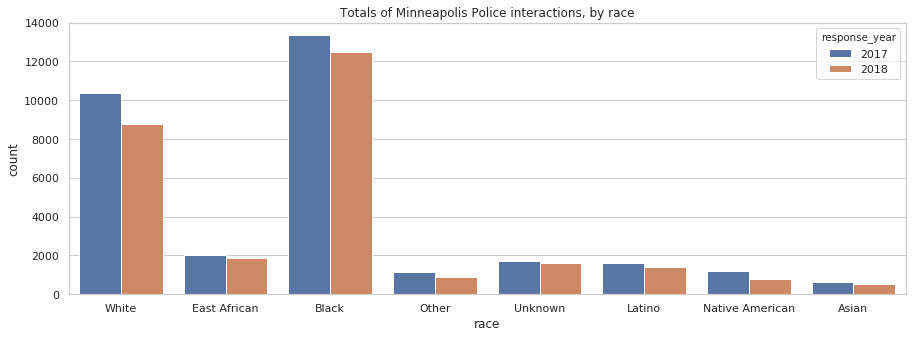

In [153]:
plt.subplots(figsize=(15,5))
overall = sns.countplot(x='race',
            hue='response_year',
            data=df.loc[(df['callDisposition'].isin(interactions)) & \
                        (df['response_year'] > 2016) & \
                        (df['response_year'] < 2019)],
           )
title = plt.title('Totals of Minneapolis Police interactions, by race')

## 2. Drop in severity of dispositions

For this section, we are only looking at calls that ended with an arrest, citation, or vehicle tow. If the implicit bias/procedural justice training is successful, we should see over time that calls end with fewer of these dispositions, ideally in favor of advisory dispositions--a verbal warning, or what is referred to as "Sent" in this data set, where suspects are merely asked to leave the scene.

If we use 2017 as a base (being the first full year of available data), we can measure subsequent years against it to determine whether or not the severity of call dispositions drops over time. 2018 is the only other available full year, so as with the number of calls above, it may not show a significant difference, but we can use it to show how future years will be measured.

The combinations of problem and call disposition can be reshaped as a contingency table that we can use to calculate a chi-squared statistic and p-value. Those values can be compared to determine whether there is a difference, and how significant the difference may be.

In [76]:
disp_severe = sum([arrested,ticket_tow],[])

__Let's take a quick look at how the relevant data looks for 2017: here we have grouped records by race, problem, and call disposition, to get an idea of which combinations of these three columns show up the most frequently.__

In [78]:
df_race_problem_disp_2017 = df_interactions_2017.groupby(['race','problem','callDisposition'])\
                                                .size().reset_index(name='count')
df_race_problem_disp_2017.loc[df_race_problem_disp_2017['callDisposition'].isin(disp_severe)]\
                         .sort_values(by='count',ascending=False)

,race,problem,callDisposition,count
34,Black,Traffic Law Enforcement (P),TAG-Tagged,2477
152,White,Traffic Law Enforcement (P),TAG-Tagged,1656
31,Black,Traffic Law Enforcement (P),BKG-Booking,611
19,Black,Suspicious Person (P),BKG-Booking,535
72,Latino,Traffic Law Enforcement (P),TAG-Tagged,345
25,Black,Suspicious Vehicle (P),BKG-Booking,301
54,East African,Traffic Law Enforcement (P),TAG-Tagged,281
129,Unknown,Traffic Law Enforcement (P),TAG-Tagged,241
149,White,Traffic Law Enforcement (P),BKG-Booking,225
22,Black,Suspicious Person (P),TAG-Tagged,225


__Here's an example of how we can transform the dataframe above into a contingency table. For this example I am only selecting records where `race == 'Black'`, for 2017:__

In [93]:
df_pivot_2017 = df_race_problem_disp_2017.loc[(df_race_problem_disp_2017['race'] == 'Black') &
                                              (df_race_problem_disp_2017['callDisposition'].isin(disp_severe))]\
                                         .pivot(index='callDisposition',columns='problem',values='count')
df_pivot_2017.fillna(value=0,inplace=True)
df_pivot_2017

problem,Attempt Pick-Up (P),Curfew Violations (P),Suspicious Person (P),Suspicious Vehicle (P),Traffic Law Enforcement (P)
callDisposition,,,,,
BKG-Booking,121.0,1.0,535.0,301.0,611.0
TAG-Tagged,0.0,14.0,225.0,158.0,2477.0
TOW-Towed,0.0,0.0,3.0,26.0,29.0


__And here are the chi-squared stats generated for 2017 calls that ended in a "severe" disposition (a booking/arrest, or a citation/ticket, or a vehicle tow), broken down by race:__

In [94]:
dict_2017 = severity_contingency(df_race_problem_disp_2017.loc[df_race_problem_disp_2017['callDisposition']\
                                                          .isin(disp_severe)])
severity_dict_print(dict_2017)

For Asian:
 Chi-squared statistic: 43.658296624352666
 P-value: 1.783697295994587e-09
 Degrees of freedom: 3
 Critical value: 7.814727903251179

For Black:
 Chi-squared statistic: 1219.6691802646403
 P-value: 5.39294192554306e-258
 Degrees of freedom: 8
 Critical value: 15.50731305586545

For East African:
 Chi-squared statistic: 115.52926352765787
 P-value: 2.7715159597798744e-21
 Degrees of freedom: 8
 Critical value: 15.50731305586545

For Latino:
 Chi-squared statistic: 133.01240593883378
 P-value: 2.9817806666301425e-26
 Degrees of freedom: 6
 Critical value: 12.591587243743977

For Native American:
 Chi-squared statistic: 98.50721296203625
 P-value: 5.139334673592015e-19
 Degrees of freedom: 6
 Critical value: 12.591587243743977

For Other:
 Chi-squared statistic: 151.8483792782999
 P-value: 8.068688850752811e-29
 Degrees of freedom: 8
 Critical value: 15.50731305586545

For Unknown:
 Chi-squared statistic: 413.47333220297446
 P-value: 3.543342129786797e-86
 Degrees of freedom: 6

__The comparable 2018 stats look like this:__

In [96]:
df_race_problem_disp_2018 = df_interactions_2018.groupby(['race','problem','callDisposition'])\
                                                .size().reset_index(name='count')
dict_2018 = severity_contingency(df_race_problem_disp_2018.loc[df_race_problem_disp_2018['callDisposition']\
                                              .isin(disp_severe)])
severity_dict_print(dict_2018)

For Asian:
 Chi-squared statistic: 47.48440675188462
 P-value: 2.7414534057243023e-10
 Degrees of freedom: 3
 Critical value: 7.814727903251179

For Black:
 Chi-squared statistic: 1069.6689539718316
 P-value: 1.359199380321892e-225
 Degrees of freedom: 8
 Critical value: 15.50731305586545

For East African:
 Chi-squared statistic: 71.48081116973326
 P-value: 2.0310405061079938e-13
 Degrees of freedom: 6
 Critical value: 12.591587243743977

For Latino:
 Chi-squared statistic: 113.53928830059752
 P-value: 7.12195713069541e-21
 Degrees of freedom: 8
 Critical value: 15.50731305586545

For Native American:
 Chi-squared statistic: 35.53483394390339
 P-value: 2.1359192136036597e-05
 Degrees of freedom: 8
 Critical value: 15.50731305586545

For Other:
 Chi-squared statistic: 121.42265377734967
 P-value: 8.188786362164827e-24
 Degrees of freedom: 6
 Critical value: 12.591587243743977

For Unknown:
 Chi-squared statistic: 206.95559777395846
 P-value: 6.26932467755531e-42
 Degrees of freedom: 6


I believe what we would like to see is a year-over-year decrease in the chi-squared statistic for each racial category, but still above the critical value. Comparing 2017 to 2018, we can see this is true when race is Black, East African, Native American, Other, and Unknown. This measure shows some increase between 2017 and 2018 for Asian, Latino, and White racial categories unfortunately.

I spot checked out of curiosity--for Whites, the increases fall entirely under dispositions related to Traffic Law Enforcement--totals for other Problem categories dropped. For Latinos, the increases are in citations for Suspicious Person and Suspicious Vehicle, and tows for Traffic Law Enforcement. For Asians, there was a single increase--an arrest under Attempt Pick-Up. Totals for all other Problem categories for Latinos and Asians dropped from 2017 to 2018.

## 3. Reduction in racial bias, 2017 to 2018

This is a comparison of overall percentages of calls by race, where race is known. Between 2017 and 2018, there were small declines for every race except Black--so there is still work to be done here.

In [40]:
df_2017 = df.loc[(df['response_year'] == 2017) & (df['race'] != 'Unknown')]
df_2018 = df.loc[(df['response_year'] == 2018) & (df['race'] != 'Unknown')]

df_2017['race'].value_counts(normalize=True)

Black              0.442830
White              0.337493
East African       0.062400
Latino             0.053538
Native American    0.044984
Other              0.039880
Asian              0.018874
Name: race, dtype: float64

In [41]:
df_2018['race'].value_counts(normalize=True)

Black              0.470263
White              0.324391
East African       0.065425
Latino             0.053073
Other              0.034449
Native American    0.033645
Asian              0.018753
Name: race, dtype: float64

We can compare the totals to the city's total population--less biased policing practices will show a closer match to the city's actual demographics, while more bias can be seen when a race is involved in police calls disproportionate to their representation in the total municipal population.

Because this is all categorical data, we can use the chi-squared test instead of a t-test to determine how alike the sample distributions are. 

In [117]:
chi2_racial_bias(df_population, df_2017['race'])


Population
 Asian               25524.0
Black               80401.0
East African        50000.0
Latino              41689.0
Native American      5105.0
Other               20845.0
White              254816.0
Name: count, dtype: float64

Observed counts
 Asian                673
Black              15790
East African        2225
Latino              1909
Native American     1604
Other               1422
White              12034
Name: race, dtype: int64

Expected counts
 Asian               2670.660000
Black               8412.579000
East African        5231.627422
Latino              4362.078000
Native American      534.132000
Other               2181.039000
White              26662.089000
Name: percentage, dtype: float64

Chi^2 stat:
 21504.103820566794
Critical value
12.591587243743977
P value
1.0


In [44]:
chi2_racial_bias(df_population, df_2018['race'])


Population
 Asian               25524.0
Black               80401.0
East African        50000.0
Latino              41689.0
Native American      5105.0
Other               20845.0
White              254816.0
Name: count, dtype: float64

Observed counts
 Asian                583
Black              14620
East African        2034
Latino              1650
Native American     1046
Other               1071
White              10085
Name: race, dtype: int64

Expected counts
 Asian               2334.360000
Black               7353.234000
East African        4572.840342
Latino              3812.788000
Native American      466.872000
Other               1906.394000
White              23304.694000
Name: percentage, dtype: float64

Chi^2 stat:
 19715.055534650885
Critical value
12.591587243743977
P value
1.0


## Addendum--the most likely reason there are so many traffic stops in this data

[Minnpost published this article about pretext stops](https://www.minnpost.com/community-voices/2019/06/traffic-stops-as-criminal-investigations-pretext-stops-should-be-disallowed-in-minnesota) as I was completing this capstone. It provides some background on current police procedures, specifically surrounding the high number of traffic stops I spotted as I finished this research.